# Private Housing Resale Price Prediction
This file is dedicated to predicting private housing resale prices.

## Data Collection
- The following codes below in this section is dedicated to reading and combining csv files into 1 dataframe.
- We also import all necessary modules in this section as well.
- Data is retrieved from Private Residential Property Transactions from https://www.ura.gov.sg/realEstateIIWeb/transaction/search.action .

In [43]:
# Necessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import datetime
import glob

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import *

In [44]:
# Read csv files for private housing data
privateHouseFile = "../dataset/sale-prediction/private-housing/*.csv"
all_private_sales = glob.glob(privateHouseFile)

listOfPrivate = []
for filename in all_private_sales:
    df = pd.read_csv(filename, skiprows=1)
    listOfPrivate.append(df)

privateDf = pd.concat(listOfPrivate, axis=0)
privateDf.reset_index(drop=True, inplace=True)
privateDf.head()

,S/N,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Nett Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm),Date of Sale
0,1,ECHELON,ALEXANDRA VIEW,Condominium,03,RCR,99 yrs lease commencing from 2012,Resale,1.0,2000000.0,-,93.0,Strata,41 to 45,21505.0,May-2021
1,2,CARIBBEAN AT KEPPEL BAY,KEPPEL BAY DRIVE,Condominium,04,RCR,99 yrs lease commencing from 1999,Resale,1.0,2300000.0,-,141.0,Strata,01 to 05,16312.0,May-2021
2,3,LUMIERE,MISTRI ROAD,Apartment,02,CCR,99 yrs lease commencing from 2006,Resale,1.0,1251300.0,-,60.0,Strata,36 to 40,20855.0,May-2021
3,4,ASCENTIA SKY,ALEXANDRA VIEW,Condominium,03,RCR,99 yrs lease commencing from 2008,Resale,1.0,2530000.0,-,169.0,Strata,16 to 20,14970.0,May-2021
4,5,HUNDRED TREES,WEST COAST DRIVE,Condominium,05,OCR,956 yrs lease commencing from 1928,Resale,1.0,1150000.0,-,73.0,Strata,01 to 05,15753.0,May-2021


### Exploratory Data Analysis (EDA)
- In this section, we will examine the data that we have collected earlier.
- We will check data types of columns, check any outliers, visualising correlations between features and etc.

In [45]:
privateDf.shape

(63895, 16)

In [46]:
privateDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63895 entries, 0 to 63894
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S/N                63748 non-null  object 
 1   Project Name       63853 non-null  object 
 2   Street Name        63619 non-null  object 
 3   Type               63618 non-null  object 
 4   Postal District    63618 non-null  object 
 5   Market Segment     63601 non-null  object 
 6   Tenure             63597 non-null  object 
 7   Type of Sale       63601 non-null  object 
 8   No. of Units       63601 non-null  float64
 9   Price ($)          63601 non-null  float64
 10  Nett Price ($)     63601 non-null  object 
 11  Area (Sqm)         63601 non-null  float64
 12  Type of Area       63601 non-null  object 
 13  Floor Level        63601 non-null  object 
 14  Unit Price ($psm)  63601 non-null  float64
 15  Date of Sale       63601 non-null  object 
dtypes: float64(4), object(

In [47]:
# Find out mean, median, standard deviation, etc
# Data comes from 1990 to 2021
privateDf.describe()

,No. of Units,Price ($),Area (Sqm),Unit Price ($psm)
count,63601.000000,6.360100e+04,63601.000000,63601.000000
mean,1.104951,2.349279e+06,164.658873,13938.754139
std,4.725084,1.242689e+07,747.378357,5505.148333
min,1.000000,4.000000e+04,24.000000,355.000000
25%,1.000000,1.005000e+06,89.000000,10194.000000
50%,1.000000,1.428000e+06,116.000000,12773.000000
75%,1.000000,2.300000e+06,159.000000,16400.000000
max,560.000000,9.800000e+08,87986.000000,64848.000000


The following boxplot graphs below will help us to visualise data better instead of using the 'describe' function used earlier.

(0.0, 10000000.0)

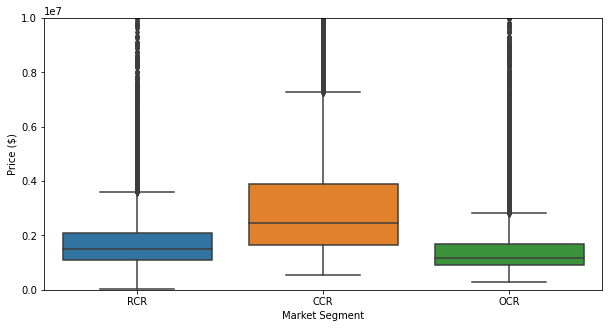

In [48]:
# Need to speicfy figure size before displaying boxplot below
plt.figure(figsize=[10,5])

sns.boxplot(x="Market Segment", y="Price ($)", data=privateDf)
# Max value is 10 million dollars
plt.ylim(0,10000000)

# From the boxplot below, we can tell that the CCR region median is higher than RCR and OCR.
# Also we do not intend to drop any outliers as they will increase varibility.
# There's actually more data points above 10 million but I've set the limit so that we can see the majority of the values below 10 million dollars.

<AxesSubplot:xlabel='Market Segment', ylabel='Unit Price ($psm)'>

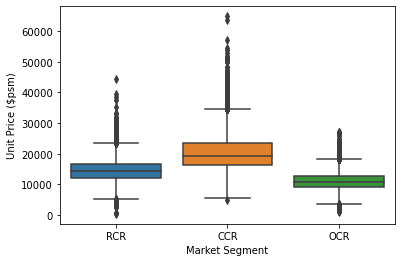

In [49]:
sns.boxplot(x="Market Segment", y="Unit Price ($psm)", data=privateDf)


<AxesSubplot:xlabel='Type', ylabel='Price ($)'>

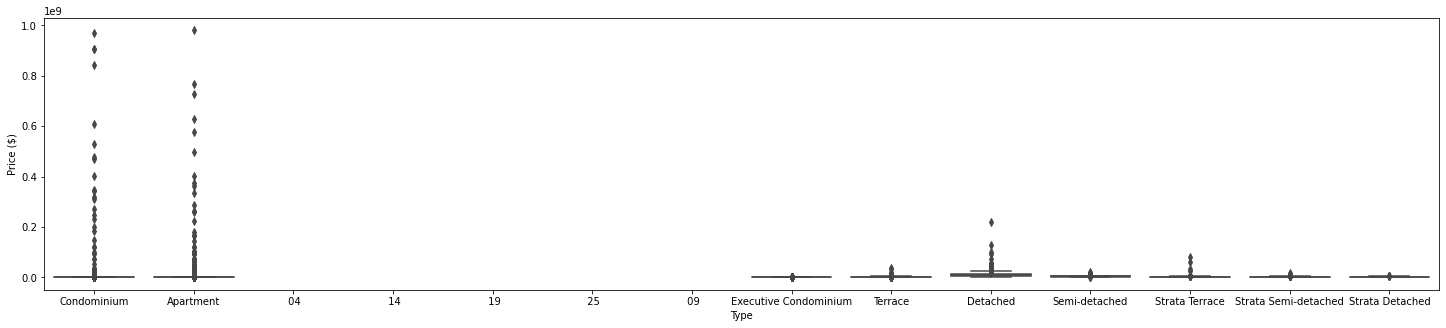

In [53]:
plt.figure(figsize=[25,5])

sns.boxplot(x="Type", y="Price ($)", data=privateDf)

## Data Preparation
- In this section, we will check if our data contains null/empty values and fill in empty data with mean values.
- We will also convert column data to correct data types.

In [ ]:
# All some fields are empty
# In this case, we drop unnecessary columns
privateDf.isnull().sum()

In [ ]:
# Drop project name and street name columns as they are irrelevant
# Drop S/N since we already have a index column
# Drop type of sale because we are only dealing with resale only
privateDf = privateDf.drop(['S/N','Project Name','Street Name','Type of Sale'], axis=1)
privateDf.head()

In [ ]:
privateDf = privateDf.dropna()
privateDf.isnull().sum()

## Feature Engineering
One hot encode columns for flat_models, town, storey_range, flat_type.

In [ ]:
# One hot encode these categorical columns
privateDf = pd.get_dummies(privateDf, columns=['Type','Postal District', 'Market Segment', 'flat_model','Type of Area'])
privateDf.head()

## Training Model - Regression
- Prob will decide which algo will fit the best for this project (might try xgboost)
- Needs to have validation dataset as well

In [ ]:
# X contains features
X = privateDf.drop(['resale_price'], axis=1)

# y contains targets to be predicted
y = privateDf['resale_price']

# 80% training data and 10% data for each test and validation data
X_train, X_testTotal, y_train, y_testTotal = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

#### Linear Regression
We will use a simple linear regression alogrithm for this section.

In [ ]:
reg = LinearRegression()
reg.fit(X_train,y_train)

In [ ]:
mse = mean_absolute_error(y_train, reg.predict(X_train))
print("Mean Absolute Error on training data: {:.4f}".format(mse))

mse = mean_absolute_error(y_validation, reg.predict(X_validation))
print("Mean Absolute Error on validation data: {:.4f}".format(mse))

#### XGBoost
We will be using XGBoost for this section.